In [51]:
import pandas as pd
from modalities.utils.profilers.profile_logs_analyzers import ProfileLogsAnalyzer
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


In [63]:
log_dirs = {
    "FSDP2": Path("/raid/s3/opengptx/max_lue/repositories/modalities/tutorials/scaling_up/experiments/2025-05-28__10-57-11_914579eb"), 
}
results_dict = {}
for name, log_dir in log_dirs.items():
    results = ProfileLogsAnalyzer.load_profiling_logs(log_dir)
    df = ProfileLogsAnalyzer.to_pandas_df(results)
    df["total_step_time"] = df["forward_time"] + df["backward_time"] + df["step_time"]
    df["token_throughput"] = df["sequence_length"]*df["batch_size"] / df["total_step_time"]
    df.sort_values(by=["total_step_time"], inplace=True, ascending=True)
    df["error"] = df["error"].apply(lambda x: x[:20])
    results_dict[name] = df

df = results_dict["FSDP2"].sort_values(by=["token_throughput"], ascending=False)
df.head()

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput
185,5,1024,50304,1,1,8,dgx2,52202.177246,0.095401,0.853139,0.139091,,1.087630,4707.481744
137,5,1024,50304,2,2,8,dgx2,52202.177246,0.095813,0.853130,0.139117,,1.088060,4705.623339
143,5,1024,50304,3,3,8,dgx2,52202.177246,0.095911,0.853056,0.139269,,1.088237,4704.859540
70,5,1024,50304,0,0,8,dgx2,52202.177246,0.095844,0.853124,0.139397,,1.088366,4704.301829
286,5,1024,50304,7,7,8,dgx2,52202.177246,0.096139,0.853374,0.138933,,1.088445,4703.956562


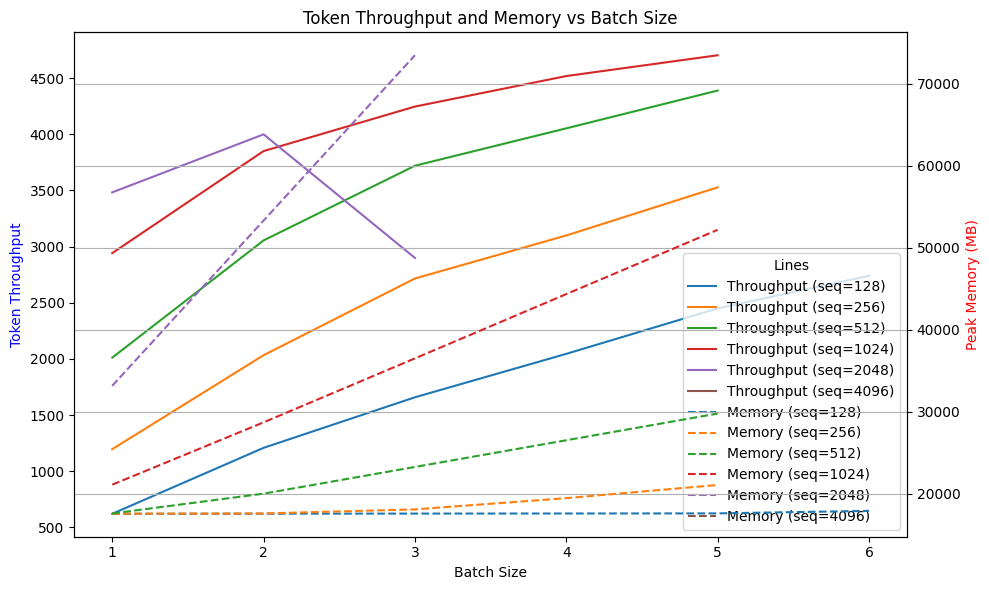

In [64]:
# Clean data
df = df[(df["token_throughput"] > 0) & (df["peak_memory"] > 0)]

# Start figure
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Color cycle for consistency across axes
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (seq_len, group) in enumerate(df.groupby("sequence_length")):
    color = colors[i % len(colors)]
    
    # Aggregate by batch_size
    grouped = group.groupby("batch_size").agg({
        "token_throughput": "mean",
        "peak_memory": "mean"
    })

    ax1.plot(grouped.index, grouped["token_throughput"], label=f"Throughput (seq={seq_len})", color=color, linestyle='-')
    ax2.plot(grouped.index, grouped["peak_memory"], label=f"Memory (seq={seq_len})", color=color, linestyle='--')

# Labels and legends
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Token Throughput", color='blue')
ax2.set_ylabel("Peak Memory (MB)", color='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right", title="Lines")

plt.title("Token Throughput and Memory vs Batch Size")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the data is sorted by peak_memory for proper line plotting
df_sorted = df.sort_values(by="peak_memory")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_sorted,
    x="peak_memory",
    y="total_step_time",
    hue="lines",  # One line per ac_mode
    marker="o"      # Add markers for clarity
)
plt.title("Total Step Time vs. Peak Memory by ac_mode")
plt.xlabel("Peak Memory (MB)")  # Adjust label if needed
plt.ylabel("Total Step Time (s)")  # Adjust label if needed
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `lines` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

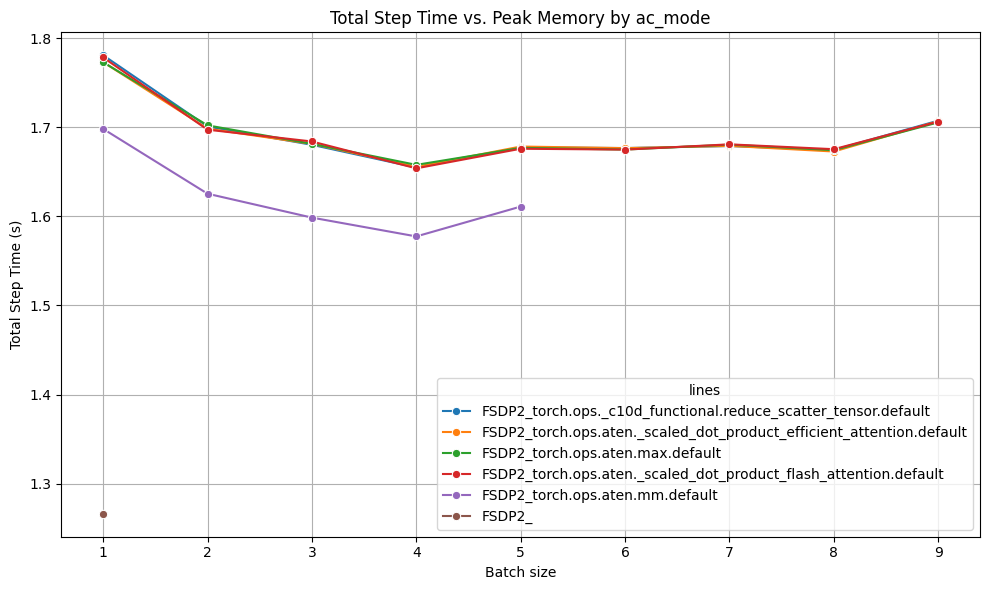

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the data is sorted by peak_memory for proper line plotting
df_sorted = combined_df.sort_values(by="peak_memory")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_sorted,
    x="batch_size",
    y="total_step_time",
    hue="lines",  # One line per ac_mode
    marker="o"      # Add markers for clarity
)
plt.title("Total Step Time vs. Peak Memory by ac_mode")
plt.xlabel("Batch size")  # Adjust label if needed
plt.ylabel("Total Step Time (s)")  # Adjust label if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
results_dict["compile"]

KeyError: 'compile'